In [263]:
import numpy as np
import matplotlib.pyplot as plt
import pyro.distributions.constraints as constraints
import scipy
import scipy.optimize as opt

In [264]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.model_selection import train_test_split
pyro.set_rng_seed(0)

In [265]:
#B1

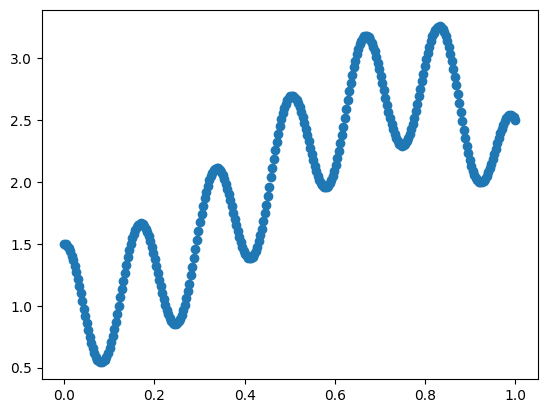

In [266]:
#Objective function
def g(x):
    return - torch.sin(6*torch.pi*x)**2 + 6 * x**2 - 5*x**4 + 3 / 2
grid = torch.linspace(0, 1, 300)
plt.scatter(x = grid, y = g(grid))
plt.show()

In [267]:
# let's plot the loss curve after 2000 steps of training
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

In [268]:
n = 30
X = torch.linspace(0, 1, 30).reshape((-1,1))
y = g(X) + dist.Normal(0.0, np.sqrt(0.01)).sample(sample_shape=(30,)).reshape((-1,1))
X, X_test, y, y_test = train_test_split(X, y, test_size=10, random_state=45)
#Consider normalise ys:
#y_mean = torch.mean(y)
#y_std = torch.std(y)
#y = (y - y_mean)/y_std

In [242]:
#numpy version
#n = 30
#X = torch.linspace(0, 1, 30).reshape((-1,1))
#y = g(X) + dist.Normal(0.0, np.sqrt(0.01)).sample(sample_shape=(30,)).reshape((-1,1))
#X, X_test, y, y_test = train_test_split(X, y, test_size=10, random_state=45)
#normalise ys:
#y = (y - torch.mean(y))/torch.std(y)
#y = np.array(y)
#X = np.array(X)

In [540]:
smoke_test = False
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    plot_target_function=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
    nump=True
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_target_function:
        ax.plot(torch.linspace(-0.5,5.5, n_test), g(torch.linspace(-0.5,5.5, n_test)))
    if plot_observed_data:
        if not nump: 
            ax.plot(X.numpy(), y.numpy(), "kx")
        else:
            ax.plot(X, y, "kx")
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        #var_gp = torch.diag(cov)
        #yout_m = mean*y_std + y_mean
        #yout_v =var_gp*y_std**2
        
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 1.96 * sd).numpy(),
            (mean + 1.96 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 2, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-3,5)

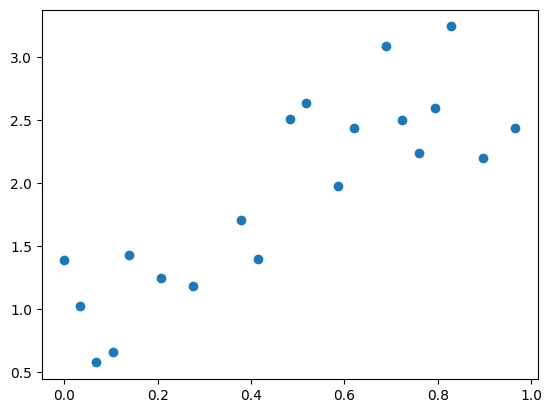

In [270]:
plt.scatter(x = X, y = y)

In [644]:
# Define the same model as before.
pyro.clear_param_store()
#kernel = gp.kernels.RBF(
#    input_dim=1, variance=torch.tensor(5.0), lengthscale=torch.tensor(10.0)
#)
kernel_per = gp.kernels.Periodic(input_dim = 1)
kernel_lin = gp.kernels.Linear(input_dim = 1)
kernel_Rbf = gp.kernels.RBF(input_dim=1)
kernel_sum = gp.kernels.Sum(kernel_lin, kernel_per)

#If numpy
#gpr = gp.models.GPRegression(X = torch.from_numpy(X).flatten(), y = torch.from_numpy(y).flatten(), kernel = kernel_sum, jitter=2e-3)
gpr = gp.models.GPRegression(X = X.flatten(), y = y.flatten(), kernel = kernel_sum, jitter=1e-4)

#note that our priors have support on the positive reals
def sample_kernel():
    gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.Normal(0,5)) # Slope of linear kernel
    gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.InverseGamma(3,2)) # Slope of periodic kernel
    gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.InverseGamma(3,1)) # Lengthscale of periodic kernel
    gpr.kernel.kern1.period = pyro.nn.PyroSample(dist.InverseGamma(3,1)) # Period of periodic kernel

sample_kernel()


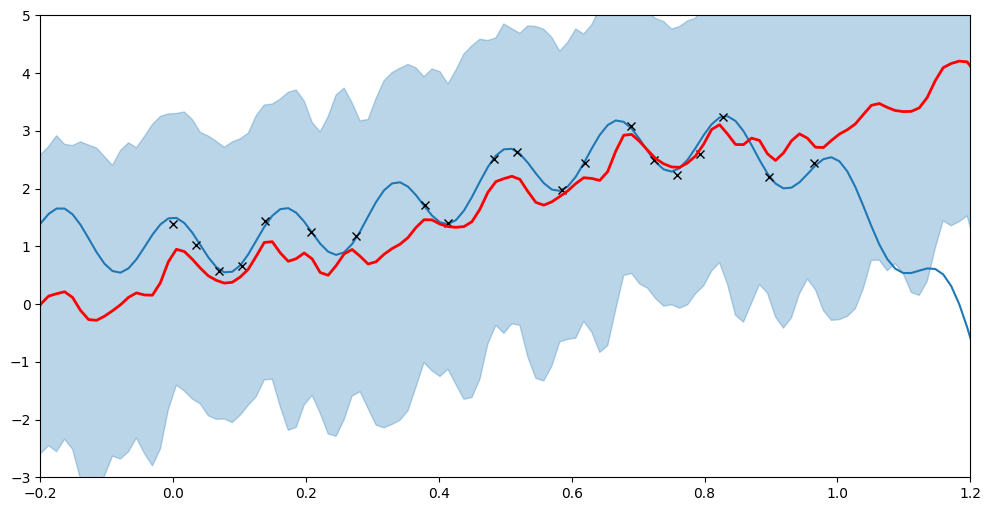

In [645]:
#Plotting the model and prior fit to training data
plot(model = gpr, kernel=gpr.kernel, plot_observed_data=True, plot_predictions=True, plot_target_function=True)  # let's plot the observed data


<module 'matplotlib.pyplot' from '/home/rasmuslovstad/Programs/assignments/pml/exam/venv/lib64/python3.11/site-packages/matplotlib/pyplot.py'>

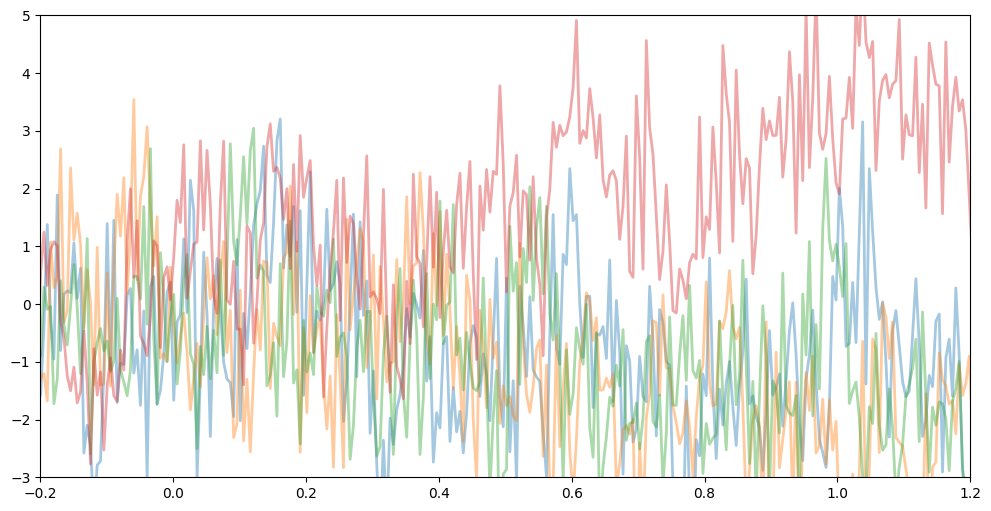

In [633]:
#Sample from prior:
#grid = torch.linspace(0,1, 101)
plot(model = gpr, kernel=gpr.kernel, plot_observed_data=False, plot_predictions=False, plot_target_function=False, n_prior_samples=4)
plt

In [311]:
loc_prior, cov_prior = gpr(X_test.flatten(), full_cov = False)
loc_prior = loc_prior.detach()
cov_prior = cov_prior.detach()
#Now compute PRIOR likelihood of the test dataset:
#Evaluate the true y'_i in the guassian at test x'_i
loglike_prior = 0
for i in range(y_test.shape[0]):
    lkhd = scipy.stats.multivariate_normal(loc_prior[i], cov_prior[i])
    loglike_prior += np.log(lkhd.pdf(y_test[i]))
print(loglike_prior)

-8.286356172046023


In [312]:
#Inspired by pyros implementation of kernels
def kernel_per(X, Xprime, eta):
    var = eta[0]
    lscale = eta[1]
    per = eta[2]
    d = X.unsqueeze(1) - Xprime.unsqueeze(0)
    scaled_sin = torch.sin(torch.pi * d / per) / lscale
    result = var * torch.exp(-2 * (scaled_sin**2).sum(-1))
    return result

def kernel_lin(X, Xprime, var):
    #return var*X @ Xprime.T
    return var * X@Xprime.T

def kernel_sum(X, Xprime, eta):
    var_lin = eta[0]
    var = eta[1]
    lscale = eta[2]
    per = eta[3]
    return kernel_per(X,Xprime, [var,lscale,per]) + kernel_lin(X,Xprime, var_lin)

def kernel_RBF(X, Z, eta):
    lengthscale = eta[0]
    variance = eta[1]
    
    scaled_X = X / lengthscale
    scaled_Z = Z / lengthscale
    X2 = (scaled_X**2).sum(1, keepdim=True)
    Z2 = (scaled_Z**2).sum(1, keepdim=True)
    XZ = scaled_X.matmul(scaled_Z.t())
    r2 = X2 - 2 * XZ + Z2.t()
    r2 = r2.clamp(min=0)
    return variance * torch.exp(-0.5 * r2)

In [250]:
def negLogLikelihood(params, kernel):
    noise_y = params[0]
    eta = params[1:]
    # todo: calculate the negative loglikelihood (See section 6.3 in the lecture notes)
    sign, det = np.linalg.slogdet(noise_y * np.identity(y.shape[0])+ kernel(X, X, eta).numpy())
    logdet = sign*det
    ll = (-1/2*y.T.numpy() @ np.linalg.inv(noise_y * np.identity(y.shape[0]) + kernel(X, X, eta).numpy()) @ y.numpy() 
             - 1/2 * logdet - y.shape[0]/2 * np.log(np.sqrt(2*np.pi))) 
    if np.isinf(ll):
        return np.inf
    return -ll

def optimize_params(ranges, kernel, Ngrid):
    opt_params = opt.brute(lambda params: negLogLikelihood(params, kernel), ranges, Ns=Ngrid, finish=None)
    #noise_var = opt_params[0]
    #eta = opt_params[1:]
    nll = negLogLikelihood(opt_params, kernel) # NOTE: added
    print(f"optimized NLL={nll}")
    return opt_params

In [20]:
kernel = kernel_sum
ranges = ((1.e-4,10),(1.e-4,10),(1.e-4,10),(1.e-4,10),(0.00001, 2.*np.pi)) 
Ngrid = 10
eta = optimize_params(ranges, kernel, Ngrid)
#Use eta as initial values for the guide in optimization
eta = torch.from_numpy(eta)
print(eta)

optimized NLL=[[-4151.67901226]]
tensor([1.0000e-04, 7.7778e+00, 1.1112e+00, 8.8889e+00, 1.0000e-05],
       dtype=torch.float64)


In [251]:
trace = pyro.poutine.trace(gpr.guide).get_trace()
#Check the values of the guide
for name, node in trace.nodes.items():
    if node["type"] == "sample":
        print(f"Site: {name}, Distribution: {node['fn']}")

Site: kernel.kern0.variance, Distribution: Delta(v: Parameter containing:
tensor(3.2224, requires_grad=True), log_density: 0.0)
Site: kernel.kern1.lengthscale, Distribution: Delta(v: 1.27620267868042, log_density: 0.0)
Site: kernel.kern1.period, Distribution: Delta(v: 0.22761236131191254, log_density: 0.0)


In [252]:
param_store = pyro.get_param_store()
param_store.keys()

dict_keys(['kernel.kern0.variance_map', 'kernel.kern1.period_map', 'kernel.kern1.lengthscale_map', 'kernel.kern1.variance', 'noise'])

In [253]:
#Setting parameters to good initial values for optimization
for i, (name, value) in enumerate(param_store.items()):
    print(f"Parameter: {name}, Value: {value}")
    param_store[name] = eta[i]

Parameter: kernel.kern0.variance_map, Value: Parameter containing:
tensor(3.2224, requires_grad=True)
Parameter: kernel.kern1.period_map, Value: 0.22761236131191254
Parameter: kernel.kern1.lengthscale_map, Value: 1.27620267868042
Parameter: kernel.kern1.variance, Value: 5.0
Parameter: noise, Value: 1.0


In [106]:
trace = pyro.poutine.trace(gpr.guide).get_trace()
#Check the values of the guide
for name, node in trace.nodes.items():
    if node["type"] == "sample":
        print(f"Site: {name}, Distribution: {node['fn']}")

Site: kernel.kern0.variance, Distribution: Delta(v: Parameter containing:
tensor(-1.7783, requires_grad=True), log_density: 0.0)
Site: kernel.kern1.lengthscale, Distribution: Delta(v: 0.4392279088497162, log_density: 0.0)
Site: kernel.kern1.period, Distribution: Delta(v: 0.7765781879425049, log_density: 0.0)


[Iteration 0000] loss: 35.2491
[Iteration 0200] loss: 20.7740
[Iteration 0400] loss: 18.0519
[Iteration 0600] loss: 17.9025
[Iteration 0800] loss: 17.9019
[Iteration 1000] loss: 17.9019
[Iteration 1200] loss: 17.9019
[Iteration 1400] loss: 17.9030
[Iteration 1600] loss: 17.9020
[Iteration 1800] loss: 17.9019


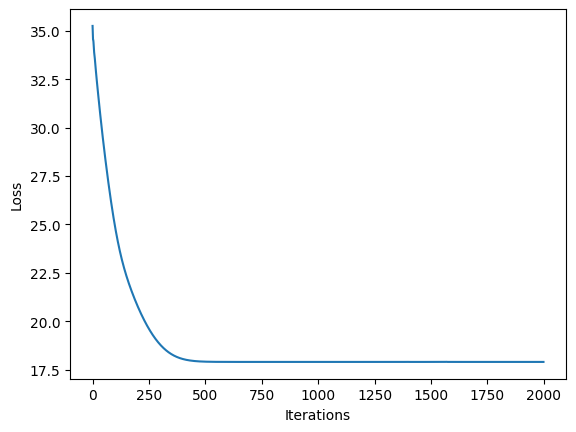

In [646]:
gpr.set_mode("model")
#Train with SVI:
adam = pyro.optim.Adam({"lr": 0.01})

svi=pyro.infer.SVI(gpr.model, gpr.guide, adam, loss=pyro.infer.Trace_ELBO())

#pyro.clear_param_store()

# Optimize the ELBO
elbo=[]
for j in range(0, 2000):
    loss=svi.step()
    elbo.append(loss)
    if j%200==0:
        print("[Iteration %04d] loss: %.4f" % (j, loss))
plot_loss(elbo)

In [116]:
# gpr.set_mode("guide")
# print("Periodic variance = {}".format(gpr.kernel.variance))
# print("Periodic lengthscale = {}".format(gpr.kernel.lengthscale))

# print("noise = {}".format(gpr.noise))

In [93]:
trace = pyro.poutine.trace(gpr.guide).get_trace()
#Check the values of the guide
for name, node in trace.nodes.items():
    if node["type"] == "sample":
        print(f"Site: {name}, Distribution: {node['fn']}")

Site: kernel.kern0.variance, Distribution: Delta(v: 0.8213724493980408, log_density: 0.0)
Site: kernel.kern1.lengthscale, Distribution: Delta(v: 0.6573633551597595, log_density: 0.0)
Site: kernel.kern1.period, Distribution: Delta(v: 0.5091977119445801, log_density: 0.0)


In [647]:
gpr.set_mode("guide")
print("Linear variance = {}".format(gpr.kernel.kern0.variance.item()))
print("Periodic lengthscale = {}".format(gpr.kernel.kern1.lengthscale.item()))
print("Periodic period = {}".format(gpr.kernel.kern1.period.item()))
print("Periodic Variance = {}".format(gpr.kernel.kern1.variance.item()))
print("noise = {}".format(gpr.noise.item()))


Linear variance = 3.0925397872924805
Periodic lengthscale = 0.48619911074638367
Periodic period = 0.675189733505249
Periodic Variance = 0.5864174365997314
noise = 0.033559609204530716


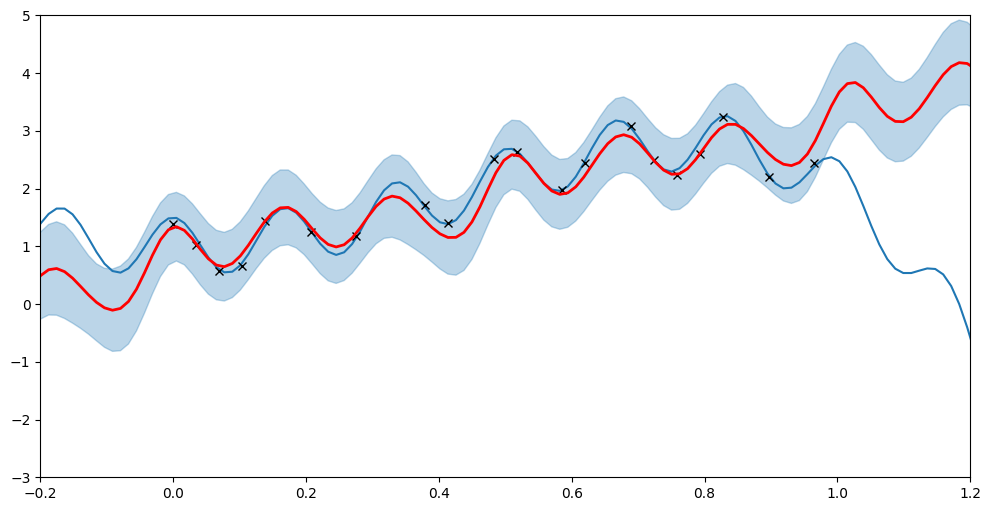

In [635]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True, plot_target_function=True, nump = False)

In [95]:
#B1.2:
gpr.set_mode("guide")
loc, cov = gpr(X_test.flatten(), full_cov = False)
loc = loc.detach()
cov = cov.detach()

In [86]:
#Now compute posterior likelihood of the test dataset:
#Evaluate the true y'_i in the guassian at test x'_i
loglike = 0
for i in range(y_test.shape[0]):
    lkhd = scipy.stats.multivariate_normal(loc[i], cov[i])
    loglike += np.log(lkhd.pdf(y_test[i]))
print(loglike)

-10.468255472150597


In [87]:
#NUTS part
#Increased warmup samples to get higher ess_tail and better r_hat towards 1.
nuts_kernel = pyro.infer.NUTS(gpr.model)
mcmc = pyro.infer.MCMC(nuts_kernel, warmup_steps = 100 , num_samples = 500, num_chains = 3)
mcmc.run()

Warmup [1]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/600 [00:00, ?it/s]

/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 

In [88]:
samples = mcmc.get_samples()

In [89]:
import arviz
data = arviz.from_pyro(mcmc)
summary = arviz.summary(data)
print(summary)

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.variance     1.441  1.087   0.229    3.316      0.070    0.050   
kernel.kern1.lengthscale  0.667  0.518   0.142    1.258      0.040    0.028   
kernel.kern1.period       0.514  0.414   0.113    1.037      0.174    0.130   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.variance        161.0     126.0   1.05  
kernel.kern1.lengthscale     112.0     160.0   1.04  
kernel.kern1.period            4.0      41.0   1.92  


/Users/Master/Documents/Kandidat/PML/Exercises/.venv/lib/python3.11/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


array([<Axes: title={'center': 'kernel.kern0.variance'}>,
       <Axes: title={'center': 'kernel.kern1.lengthscale'}>,
       <Axes: title={'center': 'kernel.kern1.period'}>], dtype=object)

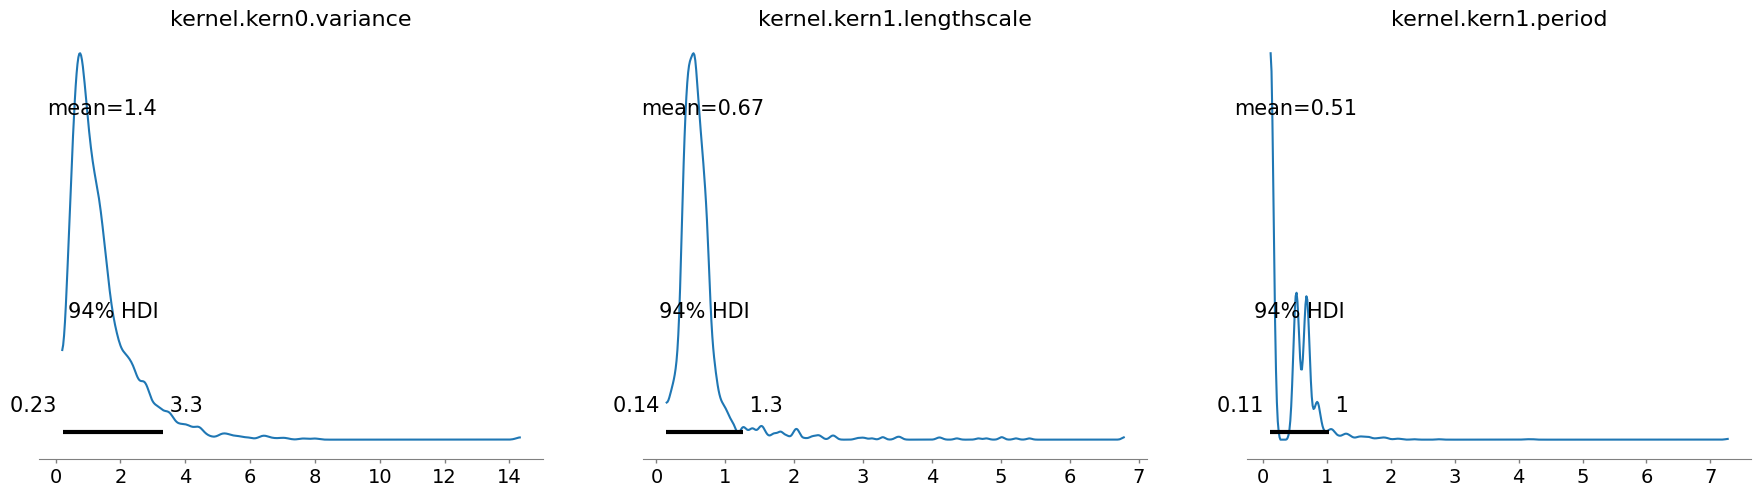

In [90]:
arviz.plot_posterior(data)

In [54]:
#B1.4:
lin_var = samples['kernel.kern0.variance']
per_var = samples['kernel.kern1.variance']
per_ls = samples['kernel.kern1.lengthscale']
per_per = samples['kernel.kern1.period']
gpr_noise = samples['noise']
samples

{'kernel.kern0.variance': tensor([0.2693, 0.5947, 0.4666,  ..., 3.5199, 3.7289, 4.8192]),
 'kernel.kern1.lengthscale': tensor([1.6144, 3.7457, 3.5723,  ..., 4.1273, 2.3495, 3.0585]),
 'kernel.kern1.period': tensor([0.9941, 0.9873, 0.8849,  ..., 0.9324, 0.9153, 0.8885]),
 'kernel.kern1.variance': tensor([1.6587, 3.3200, 3.8769,  ..., 1.5932, 3.2058, 2.2049]),
 'noise': tensor([0.1434, 0.2016, 0.1105,  ..., 0.1116, 0.2865, 0.1155])}

In [55]:
#Put next 3 cells in a loop
loglikeList = np.zeros(500)
for i in range(500):
    params = [lin_var[i], per_var[i], per_ls[i], per_per[i]]
    G = torch.linalg.inv(kernel_sum(X,X, params) + gpr_noise[i]*torch.eye(X.shape[i]))
    alpha = G@y

    mu_pred = kernel_sum(X, X_test, params).T@alpha
    var_pred = kernel_sum(X_test,X_test, params) - kernel_sum(X,X_test, params).T@G@kernel_sum(X,X_test, params)
    loglike = 0
    for j in range(y_test.shape[0]):
        lkhd = scipy.stats.multivariate_normal(mu_pred[j], var_pred[j,j])
        loglike += np.log(lkhd.pdf(y_test[j]))
    loglikeList[i] = loglike

NameError: name 'lin_var' is not defined

In [437]:
def condition_on_q(kernel, q_hat, X_predict):
    l = X_predict.size(0)
    w = torch.tensor(1/(l-1)).repeat((l,1))   
    #change first and last element
    w[0] = 1/(2*l-1)
    w[-1] = 1/(2*l-1)
    K = gpr.kernel.forward(X_predict)
    f_mu = K@w*(w.T@K@w)**-1*q_hat
    f_Sigma = K - K@w*(w.T@K@w)**-1*w.T@K
    return f_mu, f_Sigma

In [438]:
f_mu, f_Sigma = condition_on_q(gpr.kernel.forward, 2, torch.linspace(0,1,101).view(-1))

In [439]:
#Check if for positive definiteness if all eigenvalues are positive
torch.any(torch.linalg.eigh(f_Sigma + 1e-4*torch.eye(l))[0] <= 0.0)
#torch.min(torch.linalg.eigh(f_Sigma)[0])

tensor(False)

In [440]:
f_dist = torch.distributions.MultivariateNormal(f_mu.view(-1), f_Sigma + 1e-4 * torch.eye(101))
sample = f_dist.sample((5,))

In [434]:
def integrate_model(test_data):
    return f_mu.view(-1), f_Sigma + 1e-4 * torch.eye(l)

In [435]:
# Sanity check - should be close to q_hat for all samples
w.T @ sample[0]

tensor([2.0010])

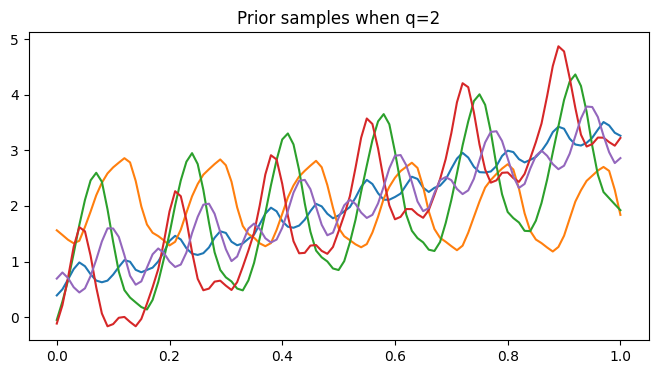

In [648]:
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(5):
    ax.plot(X_2.flatten(), sample[i])
plt.title(f"Prior samples when q={q_hat}")
#plt.savefig("integrative-prior-samples")
plt.show()

In [504]:
D_x = torch.tensor([0, 0.25, 0.5])
D_y = torch.tensor([1.46, 0.93, 2.76])

In [505]:
def conditional(X, y, X_predict, noise_var, kernel):
  #kernel_matrix = np.array([[kernel(X[row].reshape(-1,1), X[col].reshape(-1,1), eta) for col in range(len(y))] for row in range(len(y))]).reshape((len(X), len(X)))
  kernel_matrix = kernel(X)
  G = torch.linalg.inv(kernel_matrix + noise_var * torch.eye(len(y)))
  k1 = kernel(X, X_predict)
  
  mustar = k1.T @ G @ y
  Sigmastar = kernel(X_predict) - k1.T @ G @ k1
  # See eq. 66 in the lecture notes. Note that there is a small error: Instead of (S) it should be K(S)

  return mustar, Sigmastar # return mean and covariance matrix

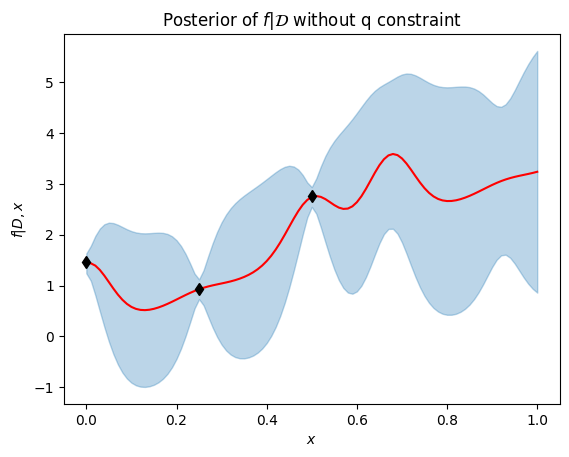

In [661]:
X_predict = torch.linspace(0,1,101)
y_pred_mu, y_pred_Sigma = conditional(D_x, D_y, X_predict, 0.01, gpr.kernel.forward)
plt.plot(X_predict, y_pred_mu.detach().numpy(), "red")
plt.fill_between(
            X_predict,  # plot the two-sigma uncertainty about the mean
            (y_pred_mu - torch.tensor(1.96) * y_pred_Sigma.diag().sqrt()).detach().numpy(),
            (y_pred_mu + torch.tensor(1.96) * y_pred_Sigma.diag().sqrt()).detach().numpy(),
            color="C0",
            alpha=0.3,
        )
plt.plot(D_x, D_y, "kd")
plt.title("Posterior of $f|\mathcal{D}$ without q constraint")
plt.xlabel("$x$")
plt.ylabel("$f|D,x$")
plt.show()

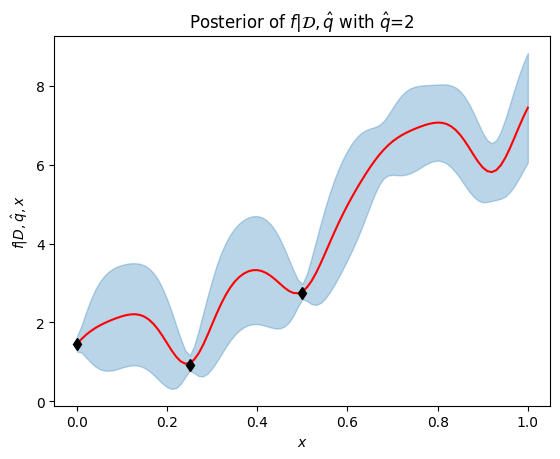

In [668]:
y_pred_mu, y_pred_Sigma = conditional(D_x, D_y, X_predict, 0.01, gpr.kernel.forward)
l = X_predict.size(0)
w = torch.tensor(1/(l-1)).repeat((l,1))   
#change first and last element
w[0] = 1/(2*l-2)
w[-1] = 1/(2*l-2)

q_hat = torch.tensor(2)
K = y_pred_Sigma
f_mu = (K@w*(w.T@K@w)**-1*q_hat).view(-1)
f_Sigma = K - K@w*(w.T@K@w)**-1*w.T@K
plt.plot(X_predict, (y_pred_mu + f_mu).detach().numpy(), "red")
plt.fill_between(
            X_predict,  # plot the two-sigma uncertainty about the mean
            (y_pred_mu + f_mu - torch.tensor(1.96) * f_Sigma.diag().sqrt()).detach().numpy(),
            (y_pred_mu + f_mu + torch.tensor(1.96) * f_Sigma.diag().sqrt()).detach().numpy(),
            color="C0",
            alpha=0.3,
        )
plt.plot(D_x, D_y, "kd")
#plt.plot(X[:5], y.view(-1)[:5], "kx")
#plt.plot(X.view(-1), y.view(-1), "kx")
plt.title("Posterior of $f|\mathcal{D},\hat{q}$ with $\hat{q}$"+f"={q_hat}")
plt.xlabel("$x$")
plt.ylabel("$f|D,\hat{q},x$")
plt.show()

In [670]:
samples = torch.distributions.MultivariateNormal(f_mu.view(-1), f_Sigma + 1e-3 * torch.eye(X_predict.size(0))).sample((100,))
np.mean([w.T @ samples[i] for i in range(100)])

1.9999721

In [671]:
w.T @ f_mu.view(-1)

tensor([2.0000], grad_fn=<MvBackward0>)